# Laplacian Associative Memory (LAM) - DEV 29

[Multiscale representations of community structures in attractor neural networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8412329/pdf/pcbi.1009296.pdf) (2021)

- Publish

In [1]:
from nn import LAM
import libtools

In [2]:
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt

---

#### DATA

In [3]:
img = np.array(PIL.Image.open("../data/images/coco/mesh.png").convert('L'), dtype=float)
img /= np.max(img)

print('Image:', img.shape)
print('min:', f"{img.min():.2f}", 'max:', f"{img.max():.2f}")

Image: (200, 200)
min: 0.00 max: 1.00


In [4]:
src = libtools.preference_map(16, 25, img.shape[0])
# src = np.load('../data/mat/SOM_orient_v1.npy')

print('Map:', src.shape)
print('min:', f"{src.min():.2f}", 'max:', f"{src.max():.2f}")

Map: (200, 200)
min: 0.00 max: 6.28


In [5]:
features = libtools.gabor_conv(img, src)
features /= np.max(features)

print('Features:', features.shape)
print('min:', f"{features.min():.2f}", 'max:', f"{features.max():.2f}")

Features: (200, 200)
min: 0.00 max: 1.00


---

### HYPER-PARAMETERS

In [6]:
factor = 4
src = libtools.downsample(src, factor)
features = libtools.downsample(features, factor)

In [7]:
N = 128**2                              # Neurons | Default: 30000
prob = 0.1                              # Sparsity
eta = 0.01                              # Epsilon / Learning rate
simlen = 3000                           # Steps / Epochs
gamma = 0.6                             # Inhibition ratio
norm_mode = 'asym'                      # Asymmetric Normalisation
alpha = -0.9                            # Ratio between local and global inhibition
P = src.shape[0] * src.shape[1]         # N Nodes

sigmaX = 0.0001                         # Spatial Gaussian Scale
sigmaA = 0.1                            # Angular Gaussian Scale

temp = 0.0215                           # Activation Probability

# Init condition (Center cell/pixel)
start_node = int(int(src.shape[0]/2) * src.shape[1] + int(src.shape[0]/2))

print('Neurons:', N)
print("Nodes:", P)
print('Start node:', start_node)
print(f"{P * 0.138:.2f} point attactors")

Neurons: 16384
Nodes: 2500
Start node: 1275
345.00 point attactors


---

### COMPUTE

In [8]:
W = libtools.construct_SLAM(src, sigmaX, sigmaA) # Adjacency Matrix

In [9]:
graph = LAM(N, P, prob, W, gamma, "asym", start_node, features, temp) # Weights

Using feature-based initial condition
Sparsity: 0.10284423828125


In [10]:
m_log, n_log, e_log = graph.simulate_single(alpha, eta, simlen) # Simulate

100%|██████████| 3000/3000 [05:44<00:00,  8.72it/s]


In [11]:
m = m_log[-1,:].copy()
# m[start_node] = m.min() # Clamp start_node

max_m = np.max(m)
Nactive = np.mean(np.sum((m > 0.5*max_m), axis=0))
print("Maximum overlap:", max_m)
print("Number of patterns:", Nactive)

Maximum overlap: 0.046740426346531215
Number of patterns: 349.0


---

### PLOT

In [12]:
# HSV2RGB
l = m + abs(m.min())
l /= l.max()

hsv_map = libtools.grade(src, 1.0, features.reshape(src.shape))

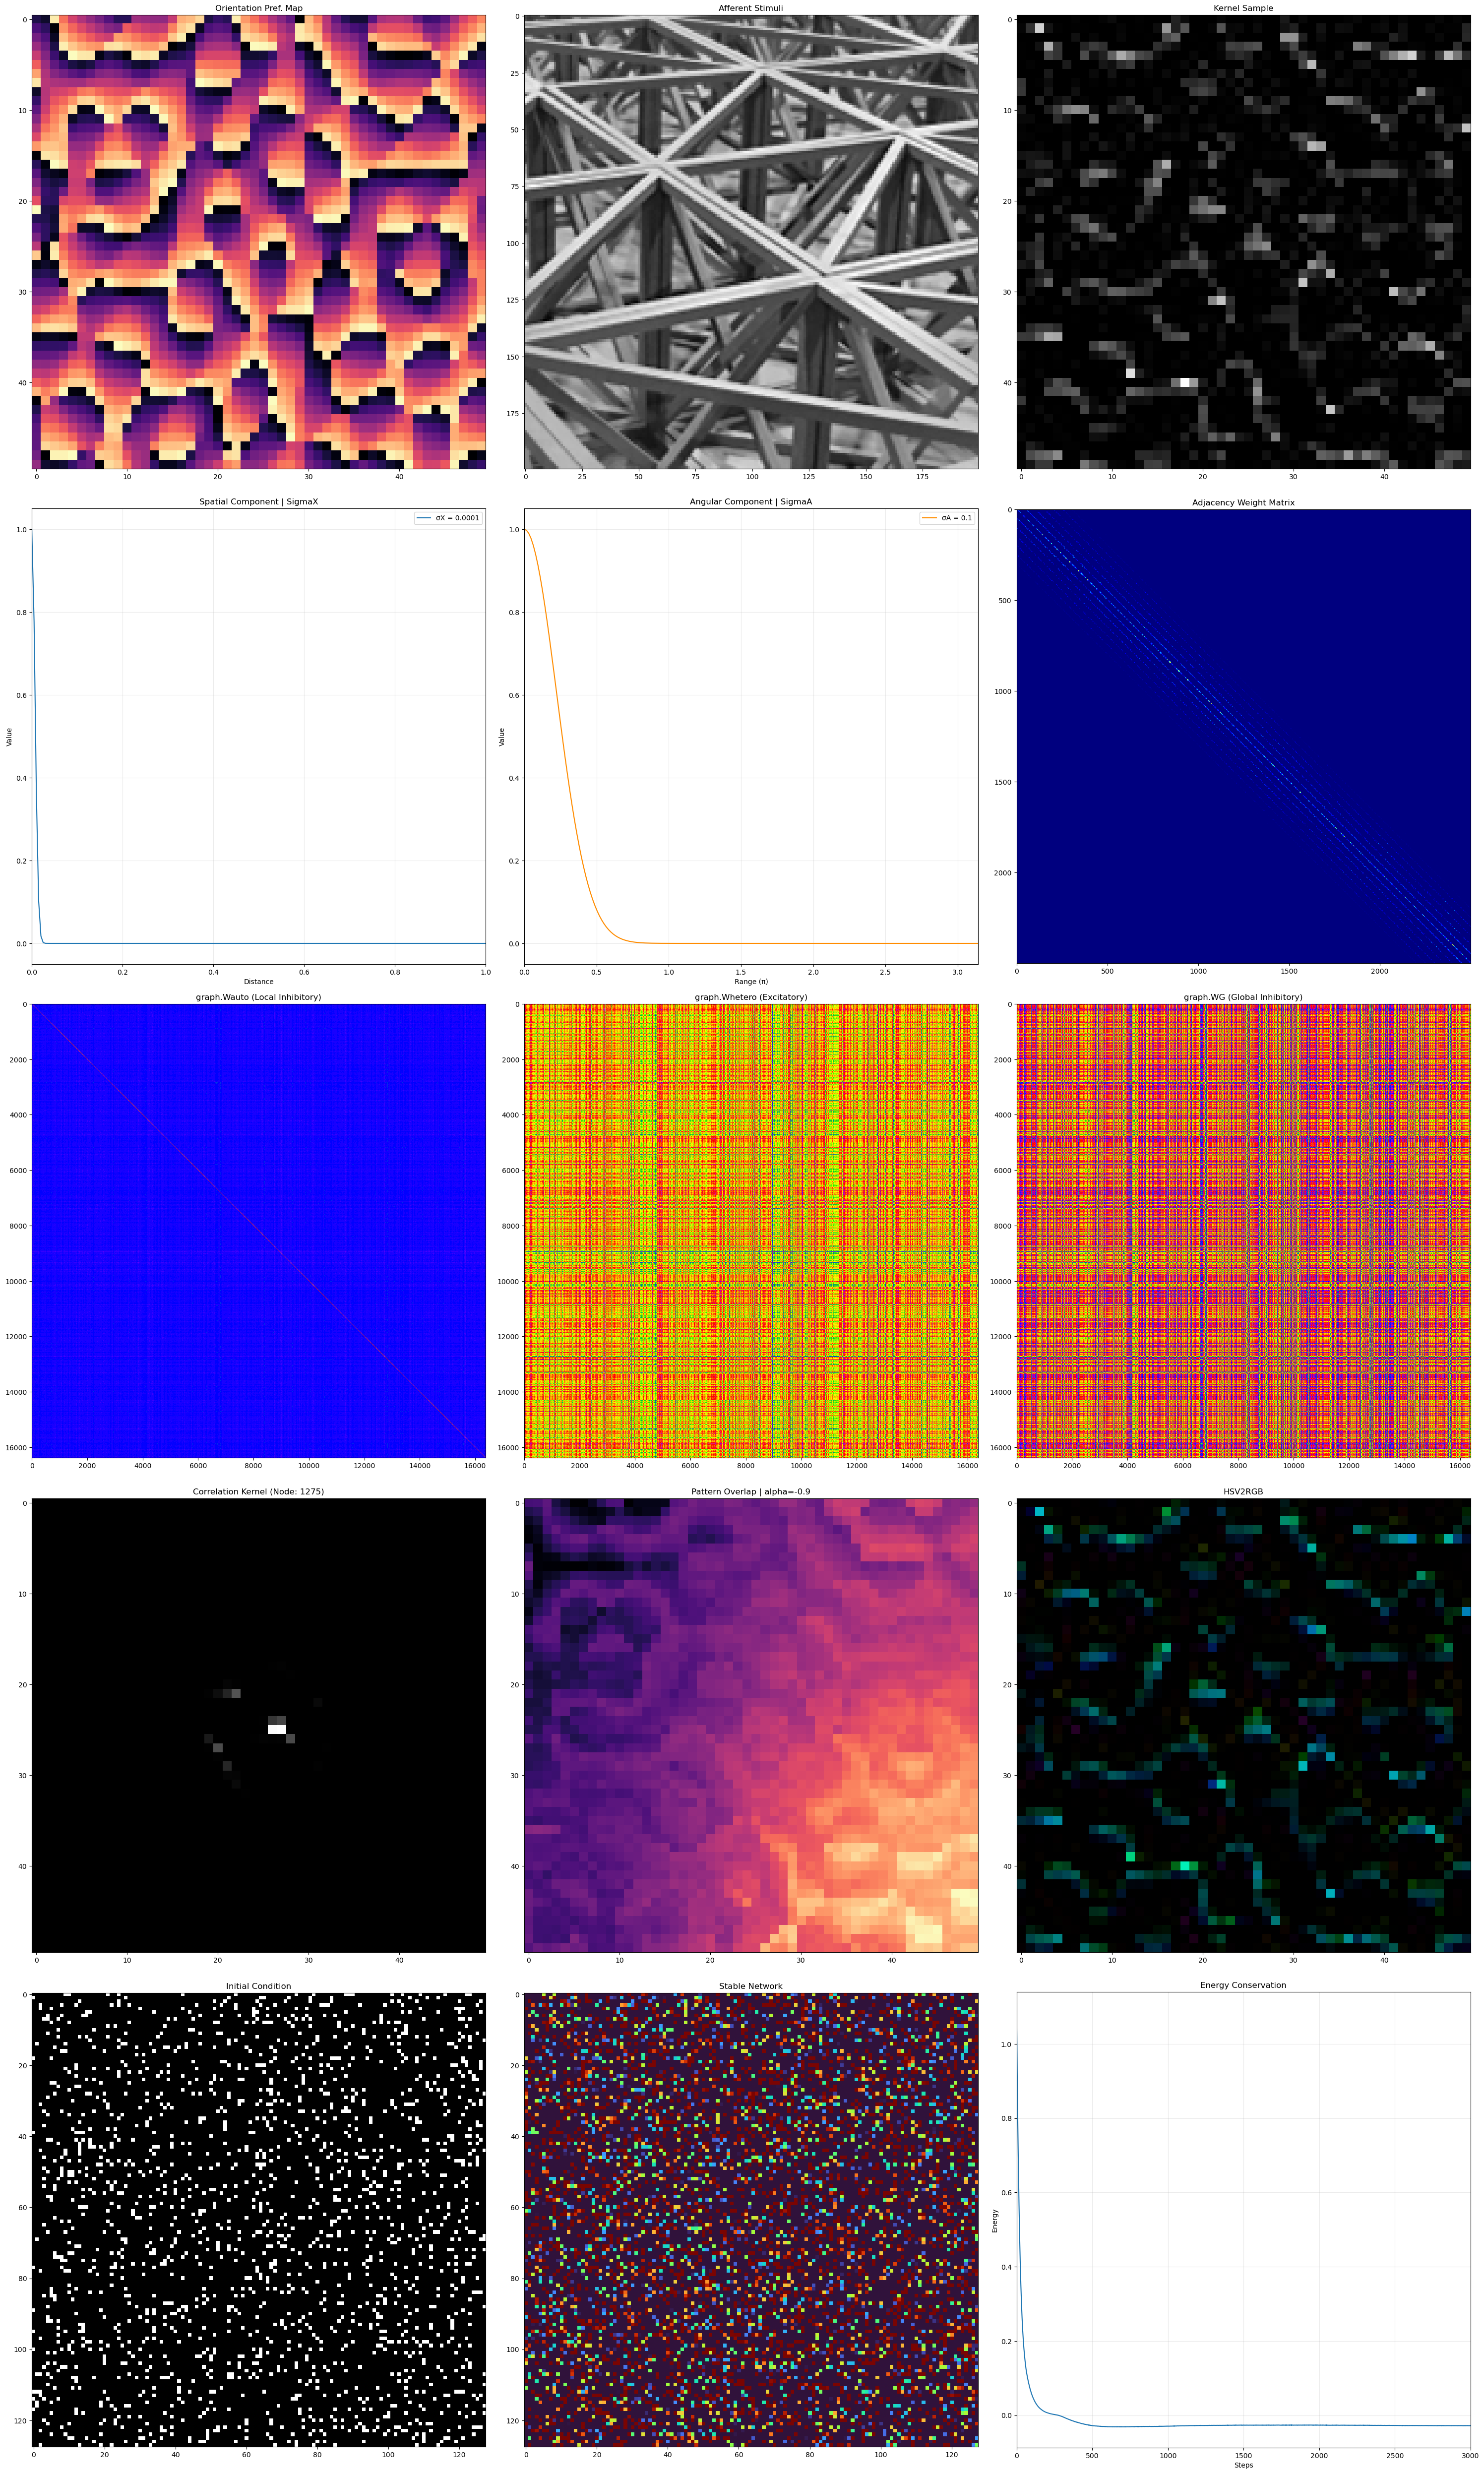

In [13]:
plt.figure(figsize=(30,50))
plt.subplot(5, 3, 1)
plt.imshow(src, 'magma')
plt.title('Orientation Pref. Map')

plt.subplot(5, 3, 2)
plt.imshow(img, 'gray')
plt.title('Afferent Stimuli')

plt.subplot(5, 3, 3)
plt.imshow(features, 'gray')
plt.title('Kernel Sample')

plt.subplot(5, 3, 4)
dist_s = np.linspace(0, 1, 200)
plt.plot(dist_s, libtools.gaussian(dist_s, sigmaX), label=f'σX = {sigmaX}')
plt.title('Spatial Component | SigmaX')
plt.xlabel('Distance'), plt.ylabel('Value')
plt.xlim([0, 1]), plt.grid(alpha=0.25), plt.legend()

plt.subplot(5, 3, 5)
dist_a = np.linspace(0, np.pi, 200)
plt.plot(dist_a, libtools.gaussian(dist_a, sigmaA), 'darkorange', label=f'σA = {sigmaA}')
plt.title('Angular Component | SigmaA')
plt.xlabel('Range (π)'), plt.ylabel('Value')
plt.xlim([0, np.pi]), plt.grid(alpha=0.25), plt.legend()

plt.subplot(5, 3, 6)
plt.imshow(W, 'jet')
plt.title('Adjacency Weight Matrix')

plt.subplot(5, 3, 7)
plt.imshow(graph.Wauto, cmap='prism')
plt.title('graph.Wauto (Local Inhibitory)')

plt.subplot(5, 3, 8)
plt.imshow(graph.Whetero, cmap='prism')
plt.title('graph.Whetero (Excitatory)')

plt.subplot(5, 3, 9)
plt.imshow(graph.WG, cmap='prism')
plt.title('graph.WG (Global Inhibitory)')

plt.subplot(5, 3, 10)
plt.imshow(W[start_node].reshape(src.shape), 'gray')
plt.title('Correlation Kernel (Node: ' + str(start_node) + ')')

plt.subplot(5, 3, 11)
plt.imshow(m.reshape(src.shape), 'magma')
plt.title("Pattern Overlap | alpha=" + str(alpha))

plt.subplot(5, 3, 12)
plt.imshow(hsv_map)
plt.title("HSV2RGB")

plt.subplot(5, 3, 13)
dim = int(N**0.5)
plt.imshow(graph.xi[:, start_node].reshape([dim,dim]), 'gray')
plt.title("Initial Condition")

plt.subplot(5, 3, 14)
plt.imshow(graph.x.reshape([dim,dim]), 'turbo')
plt.title("Stable Network")

plt.subplot(5, 3, 15)
plt.plot(e_log)
plt.title("Energy Conservation")
plt.xlabel("Steps"), plt.ylabel("Energy")
plt.xlim(0,simlen)
plt.grid(alpha=0.25)

plt.tight_layout()

In [14]:
libtools.render(m_log, src.shape, '../data/render/patternSim_proxy.gif', 'magma')

RenderIO Complete


In [15]:
libtools.render(n_log, [dim,dim], '../data/render/stateSim_proxy.gif', 'turbo')

RenderIO Complete
